In [15]:
import pandas as pd
import io

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
df = pd.read_csv("/content/drive/MyDrive/TCE/Seventh Semester/Nalaiya Thiran/Healthcare_Data/train_data.csv")
print(df)

        case_id  Hospital_code Hospital_type_code  City_Code_Hospital  \
0             1              8                  c                   3   
1             2              2                  c                   5   
2             3             10                  e                   1   
3             4             26                  b                   2   
4             5             26                  b                   2   
...         ...            ...                ...                 ...   
318433   318434              6                  a                   6   
318434   318435             24                  a                   1   
318435   318436              7                  a                   4   
318436   318437             11                  b                   2   
318437   318438             19                  a                   7   

       Hospital_region_code  Available Extra Rooms in Hospital    Department  \
0                         Z                

In [18]:
!pip install -q findspark
!pip install pyspark
!pip install matplotlib
!pip install seaborn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 43 kB/s 
     |████████████████████████████████| 199 kB 39.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845514 sha256=1eedb762e272a9eda1849610f43ba663bba4285c13b59a2439adf13a1c45da63
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Ensure spark is set up and running.

In [19]:
import findspark 
findspark.find()

'/usr/local/lib/python3.7/dist-packages/pyspark'

In [20]:
from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt

spark = SparkSession.builder.master('local')\
.appName("Predicting LOS for High Risk Patient")\
.getOrCreate()

In [21]:
spark

In [22]:
print(f"Counts of rows/samples: {df.count()}")
print(f"Counts of columns/features: {len(df.columns)}")


Counts of rows/samples: case_id                              318438
Hospital_code                        318438
Hospital_type_code                   318438
City_Code_Hospital                   318438
Hospital_region_code                 318438
Available Extra Rooms in Hospital    318438
Department                           318438
Ward_Type                            318438
Ward_Facility_Code                   318438
Bed Grade                            318325
patientid                            318438
City_Code_Patient                    313906
Type of Admission                    318438
Severity of Illness                  318438
Visitors with Patient                318438
Age                                  318438
Admission_Deposit                    318438
Stay                                 318438
dtype: int64
Counts of columns/features: 18


In [23]:
df

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318433,318434,6,a,6,X,3,radiotherapy,Q,F,4.0,86499,23.0,Emergency,Moderate,3,41-50,4144.0,11-20
318434,318435,24,a,1,X,2,anesthesia,Q,E,4.0,325,8.0,Urgent,Moderate,4,81-90,6699.0,31-40
318435,318436,7,a,4,X,3,gynecology,R,F,4.0,125235,10.0,Emergency,Minor,3,71-80,4235.0,11-20
318436,318437,11,b,2,Y,3,anesthesia,Q,D,3.0,91081,8.0,Trauma,Minor,5,11-20,3761.0,11-20


Machine Learning



In [24]:
input_variable = ['hospital', 'hospital_type', 'hospital_city','hospital_region','available_extra_rooms_in_hospital',
                  'bed_grade','city_code_patient','patient_visitors','admission_deposit',
                  'department_index', 'ward_facility_index', 'ward_type_index', 'illness_severity_index',
                  'type_of_admission_index']

label = ['stay_days_index']

Principal Component Analysis(PCA)

In [25]:
from pyspark.ml.feature import PCA

pca =PCA(k=10, inputCol="features", outputCol="pcaFeatures")

Standardization

In [26]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="pcaFeatures", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

In [27]:
pipeline = Pipeline(stages=[])

NameError: ignored

Virtualization

Correlation Matrix

Decision Tree

In [28]:
df.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  """Entry point for launching an IPython kernel.


,case_id,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Visitors with Patient,Admission_Deposit
case_id,1.00,-0.04,-0.01,0.04,0.01,-0.00,0.07,0.00,-0.05
Hospital_code,-0.04,1.00,0.13,-0.06,-0.01,0.00,-0.02,-0.03,0.05
City_Code_Hospital,-0.01,0.13,1.00,-0.05,-0.05,0.00,-0.02,0.02,-0.03
Available Extra Rooms in Hospital,0.04,-0.06,-0.05,1.00,-0.12,0.00,-0.01,0.10,-0.14
Bed Grade,0.01,-0.01,-0.05,-0.12,1.00,0.00,-0.01,0.09,0.07
patientid,-0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.01,-0.00
City_Code_Patient,0.07,-0.02,-0.02,-0.01,-0.01,0.00,1.00,-0.01,0.03
Visitors with Patient,0.00,-0.03,0.02,0.10,0.09,0.01,-0.01,1.00,-0.15
Admission_Deposit,-0.05,0.05,-0.03,-0.14,0.07,-0.00,0.03,-0.15,1.00


Random Forest

In [29]:
df.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  """Entry point for launching an IPython kernel.


,case_id,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Visitors with Patient,Admission_Deposit
case_id,1.00,-0.04,-0.01,0.04,0.01,-0.00,0.07,0.00,-0.05
Hospital_code,-0.04,1.00,0.13,-0.06,-0.01,0.00,-0.02,-0.03,0.05
City_Code_Hospital,-0.01,0.13,1.00,-0.05,-0.05,0.00,-0.02,0.02,-0.03
Available Extra Rooms in Hospital,0.04,-0.06,-0.05,1.00,-0.12,0.00,-0.01,0.10,-0.14
Bed Grade,0.01,-0.01,-0.05,-0.12,1.00,0.00,-0.01,0.09,0.07
patientid,-0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.01,-0.00
City_Code_Patient,0.07,-0.02,-0.02,-0.01,-0.01,0.00,1.00,-0.01,0.03
Visitors with Patient,0.00,-0.03,0.02,0.10,0.09,0.01,-0.01,1.00,-0.15
Admission_Deposit,-0.05,0.05,-0.03,-0.14,0.07,-0.00,0.03,-0.15,1.00


Bivariate Analysis

In [30]:
selected_list = ["11-20","21-30","41-50","61-70", "More than 100 Days"]

def bivariate_analysis(dataframe, dependent_variable, independent_variable, selected_list):
   g = sns.catplot(dependent_variable, col=independent_variable, col_wrap=3,\
   data=dataframe,kind="count", height=5, aspect=1, order=selected_list
   )


Random Forest

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


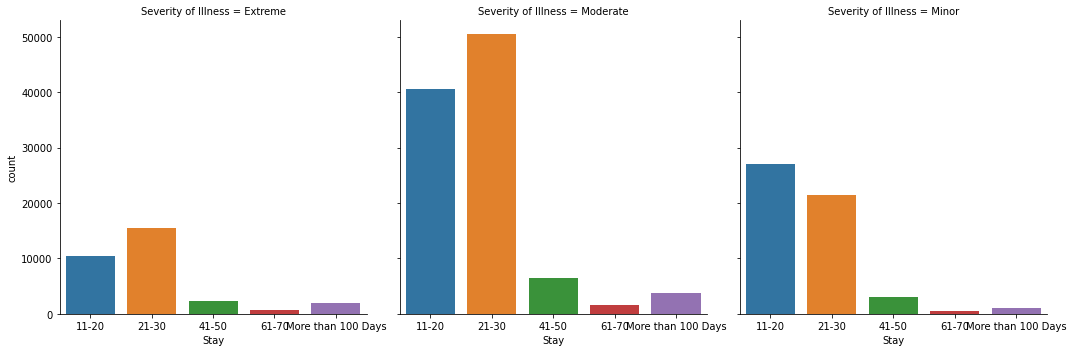

In [31]:
bivariate_analysis(df, "Stay", "Severity of Illness", selected_list)

Decision Tree

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


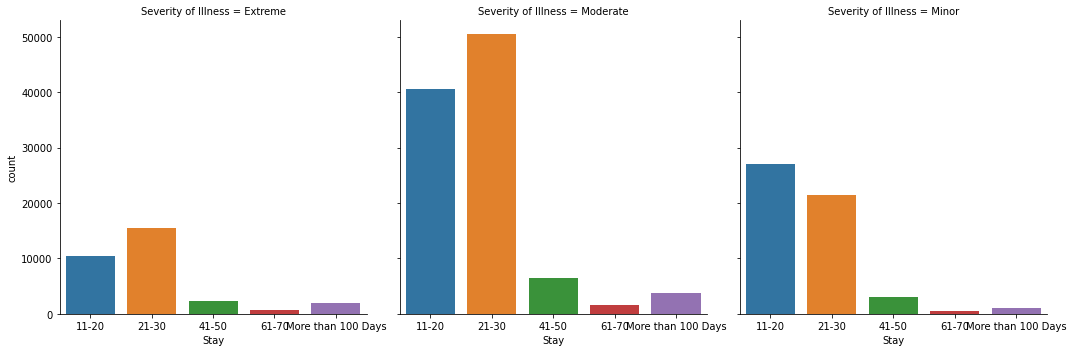

In [32]:
bivariate_analysis(df, "Stay", "Severity of Illness", selected_list)